In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import matplotlib.pyplot as plt

Data loding and preprocsseing

In [4]:
df = pd.read_csv("CarSharing.csv")

In [5]:
df

,record_date,car_rental_count,hour_of_day,temp_celsius,humidity_percent,wind_speed_mps,visibility_10m,dew_point_celsius,solar_energy_mj_m2,rain_mm,snow_cm,season_label,is_Holiday,is_working_day
0,01-12-2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01-12-2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01-12-2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01-12-2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01-12-2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30-11-2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No,Yes
8756,30-11-2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No,Yes
8757,30-11-2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No,Yes
8758,30-11-2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No,Yes


Feature engineering from date

In [6]:
df['record_date'] = pd.to_datetime(df['record_date'], dayfirst=True)

df['day_of_week'] = df['record_date'].dt.dayofweek
df['month'] = df['record_date'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

Feature engineering from hour_of_day

In [7]:
def hour_bin(hour):
    if 5 <= hour <= 9:
        return 'morning_peak'
    elif 10 <= hour <= 16:
        return 'daytime'
    elif 17 <= hour <= 21:
        return 'evening_peak'
    else:
        return 'night'

df['hour_bin'] = df['hour_of_day'].apply(hour_bin)

In [8]:
df['rolling_3h_avg'] = df['hour_of_day'].rolling(window=3).mean()

removing outlier

In [9]:
Q1 = df['car_rental_count'].quantile(0.25)
Q3 = df['car_rental_count'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['car_rental_count'] >= Q1 - 1.5 * IQR) & (df['car_rental_count'] <= Q3 + 1.5 * IQR)]

Encode categorical columns

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
ohe=OneHotEncoder(drop='first',sparse_output=False,dtype=np.int32)
ohe.fit(df[["season_label","hour_bin","is_Holiday","is_working_day"]])
dff=ohe.transform(df[["season_label","hour_bin","is_Holiday","is_working_day"]])


In [12]:
df

,record_date,car_rental_count,hour_of_day,temp_celsius,humidity_percent,wind_speed_mps,visibility_10m,dew_point_celsius,solar_energy_mj_m2,rain_mm,snow_cm,season_label,is_Holiday,is_working_day,day_of_week,month,is_weekend,hour_bin,rolling_3h_avg
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes,4,12,0,night,NaN
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes,4,12,0,night,NaN
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes,4,12,0,night,1.0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes,4,12,0,night,2.0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes,4,12,0,night,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No,Yes,4,11,0,evening_peak,18.0
8756,2018-11-30,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No,Yes,4,11,0,evening_peak,19.0
8757,2018-11-30,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No,Yes,4,11,0,evening_peak,20.0
8758,2018-11-30,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No,Yes,4,11,0,night,21.0


In [13]:
df_cat = pd.DataFrame(
    dff,
    columns=ohe.get_feature_names_out(["season_label","hour_bin","is_Holiday","is_working_day"]),
    index=df.index
)

In [14]:
df = pd.concat([df, df_cat], axis=1)

In [15]:
df

,record_date,car_rental_count,hour_of_day,temp_celsius,humidity_percent,wind_speed_mps,visibility_10m,dew_point_celsius,solar_energy_mj_m2,rain_mm,...,hour_bin,rolling_3h_avg,season_label_Spring,season_label_Summer,season_label_Winter,hour_bin_evening_peak,hour_bin_morning_peak,hour_bin_night,is_Holiday_Yes,is_working_day_Yes
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,...,night,NaN,0,0,1,0,0,1,0,1
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,...,night,NaN,0,0,1,0,0,1,0,1
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,...,night,1.0,0,0,1,0,0,1,0,1
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,...,night,2.0,0,0,1,0,0,1,0,1
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,...,night,3.0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,...,evening_peak,18.0,0,0,0,1,0,0,0,1
8756,2018-11-30,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,...,evening_peak,19.0,0,0,0,1,0,0,0,1
8757,2018-11-30,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,...,evening_peak,20.0,0,0,0,1,0,0,0,1
8758,2018-11-30,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,...,night,21.0,0,0,0,0,0,1,0,1


In [16]:
df

,record_date,car_rental_count,hour_of_day,temp_celsius,humidity_percent,wind_speed_mps,visibility_10m,dew_point_celsius,solar_energy_mj_m2,rain_mm,...,hour_bin,rolling_3h_avg,season_label_Spring,season_label_Summer,season_label_Winter,hour_bin_evening_peak,hour_bin_morning_peak,hour_bin_night,is_Holiday_Yes,is_working_day_Yes
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,...,night,NaN,0,0,1,0,0,1,0,1
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,...,night,NaN,0,0,1,0,0,1,0,1
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,...,night,1.0,0,0,1,0,0,1,0,1
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,...,night,2.0,0,0,1,0,0,1,0,1
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,...,night,3.0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,...,evening_peak,18.0,0,0,0,1,0,0,0,1
8756,2018-11-30,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,...,evening_peak,19.0,0,0,0,1,0,0,0,1
8757,2018-11-30,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,...,evening_peak,20.0,0,0,0,1,0,0,0,1
8758,2018-11-30,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,...,night,21.0,0,0,0,0,0,1,0,1


Drop irrelevent and null columns and rows

In [17]:
df = df.drop(columns=['record_date'])
df = df.drop(columns=["season_label","hour_bin","is_Holiday","is_working_day"])

In [18]:
df

,car_rental_count,hour_of_day,temp_celsius,humidity_percent,wind_speed_mps,visibility_10m,dew_point_celsius,solar_energy_mj_m2,rain_mm,snow_cm,...,is_weekend,rolling_3h_avg,season_label_Spring,season_label_Summer,season_label_Winter,hour_bin_evening_peak,hour_bin_morning_peak,hour_bin_night,is_Holiday_Yes,is_working_day_Yes
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,...,0,NaN,0,0,1,0,0,1,0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,...,0,NaN,0,0,1,0,0,1,0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,...,0,1.0,0,0,1,0,0,1,0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,...,0,2.0,0,0,1,0,0,1,0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,...,0,3.0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,...,0,18.0,0,0,0,1,0,0,0,1
8756,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,...,0,19.0,0,0,0,1,0,0,0,1
8757,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,...,0,20.0,0,0,0,1,0,0,0,1
8758,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,...,0,21.0,0,0,0,0,0,1,0,1


In [19]:
df.dropna(axis=0,inplace=True)

In [20]:
df

,car_rental_count,hour_of_day,temp_celsius,humidity_percent,wind_speed_mps,visibility_10m,dew_point_celsius,solar_energy_mj_m2,rain_mm,snow_cm,...,is_weekend,rolling_3h_avg,season_label_Spring,season_label_Summer,season_label_Winter,hour_bin_evening_peak,hour_bin_morning_peak,hour_bin_night,is_Holiday_Yes,is_working_day_Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,...,0,1.0,0,0,1,0,0,1,0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,...,0,2.0,0,0,1,0,0,1,0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,...,0,3.0,0,0,1,0,0,1,0,1
5,100,5,-6.4,37,1.5,2000,-18.7,0.0,0.0,0.0,...,0,4.0,0,0,1,0,1,0,0,1
6,181,6,-6.6,35,1.3,2000,-19.5,0.0,0.0,0.0,...,0,5.0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,...,0,18.0,0,0,0,1,0,0,0,1
8756,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,...,0,19.0,0,0,0,1,0,0,0,1
8757,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,...,0,20.0,0,0,0,1,0,0,0,1
8758,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,...,0,21.0,0,0,0,0,0,1,0,1


In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df['visibility_10m']=scaler.fit_transform(df[['visibility_10m']])

Data after preprocessing

In [22]:
df

,car_rental_count,hour_of_day,temp_celsius,humidity_percent,wind_speed_mps,visibility_10m,dew_point_celsius,solar_energy_mj_m2,rain_mm,snow_cm,...,is_weekend,rolling_3h_avg,season_label_Spring,season_label_Summer,season_label_Winter,hour_bin_evening_peak,hour_bin_morning_peak,hour_bin_night,is_Holiday_Yes,is_working_day_Yes
2,173,2,-6.0,39,1.0,1.000000,-17.7,0.0,0.0,0.0,...,0,1.0,0,0,1,0,0,1,0,1
3,107,3,-6.2,40,0.9,1.000000,-17.6,0.0,0.0,0.0,...,0,2.0,0,0,1,0,0,1,0,1
4,78,4,-6.0,36,2.3,1.000000,-18.6,0.0,0.0,0.0,...,0,3.0,0,0,1,0,0,1,0,1
5,100,5,-6.4,37,1.5,1.000000,-18.7,0.0,0.0,0.0,...,0,4.0,0,0,1,0,1,0,0,1
6,181,6,-6.6,35,1.3,1.000000,-19.5,0.0,0.0,0.0,...,0,5.0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,0.946275,-10.3,0.0,0.0,0.0,...,0,18.0,0,0,0,1,0,0,0,1
8756,764,20,3.4,37,2.3,1.000000,-9.9,0.0,0.0,0.0,...,0,19.0,0,0,0,1,0,0,0,1
8757,694,21,2.6,39,0.3,0.983781,-9.9,0.0,0.0,0.0,...,0,20.0,0,0,0,1,0,0,0,1
8758,712,22,2.1,41,1.0,0.928535,-9.8,0.0,0.0,0.0,...,0,21.0,0,0,0,0,0,1,0,1


Split data into Training and tesing 

In [23]:
X = df.drop(columns=['car_rental_count'])
y = df['car_rental_count']

y_log = np.log1p(y)

X_train, X_test, y_train_log, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

Linear Regression

In [24]:
model = LinearRegression()
model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log) 

Calculate performance

In [25]:
Linear_Regression_R2=r2_score(np.expm1(y_test), y_pred)
Linear_Regression_RMSE=np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
Linear_Regression_mae=mean_absolute_error(np.expm1(y_test), y_pred)

print("Linear Regression R²:",Linear_Regression_R2)
print("RMSE:", Linear_Regression_RMSE)
print("mae: ",Linear_Regression_mae)

Linear Regression R²: 0.5539270714697752
RMSE: 400.77949360396616
mae:  249.30335577418052


Graphical presentation

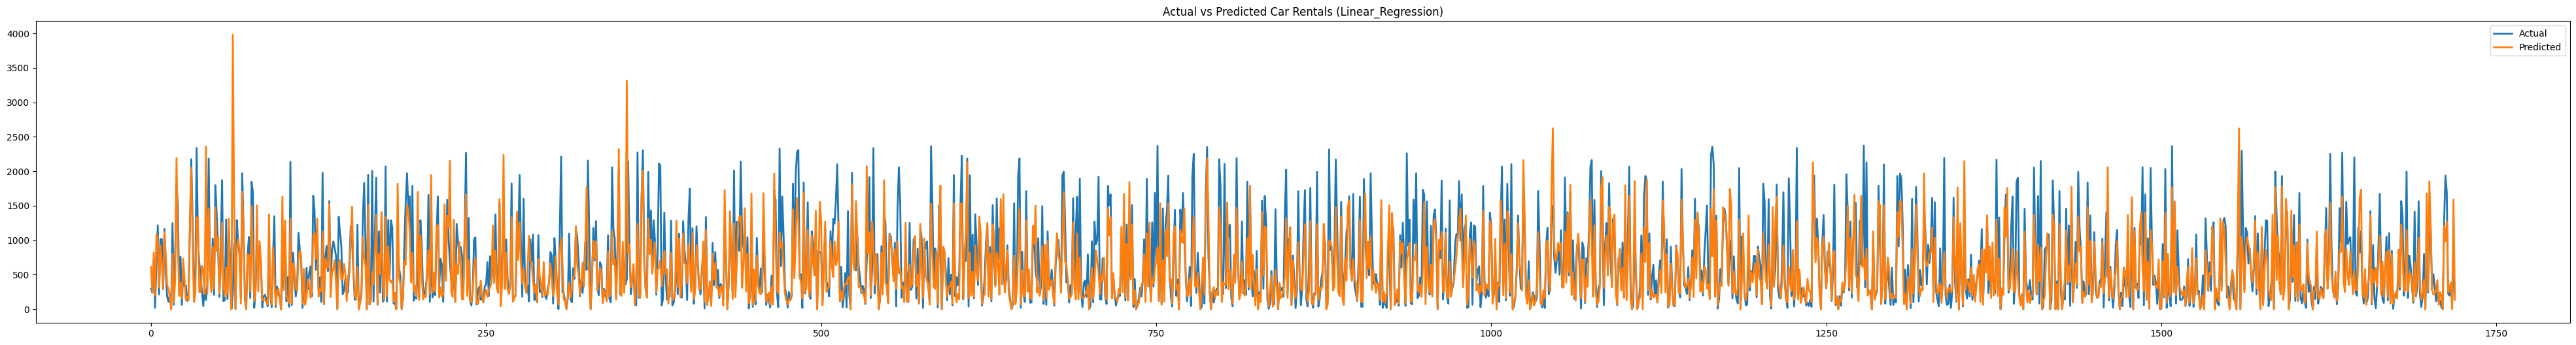

In [26]:
plt.figure(figsize=(50,6))
plt.plot((np.expm1(y_test.values)), label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linewidth=2)
plt.legend()
plt.title("Actual vs Predicted Car Rentals (Linear_Regression)")
plt.show()

Ramdom forest with GridSearchCV

In [27]:
model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train_log)
y_pred_log = grid.predict(X_test)
y_pred = np.expm1(y_pred_log) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Calculate performance

In [28]:
RandomForest_R2 =r2_score(np.expm1(y_test), y_pred)
RandomForest_RMSE=np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
RandomForest_mae=mean_absolute_error(np.expm1(y_test), y_pred)

print("Random Forest R2:",RandomForest_R2)
print("RMSE:", RandomForest_RMSE)
print("mae: ",RandomForest_mae)

Random Forest R2: 0.9155404961921809
RMSE: 174.39210558967267
mae:  95.69495579052244


Graphical presentation

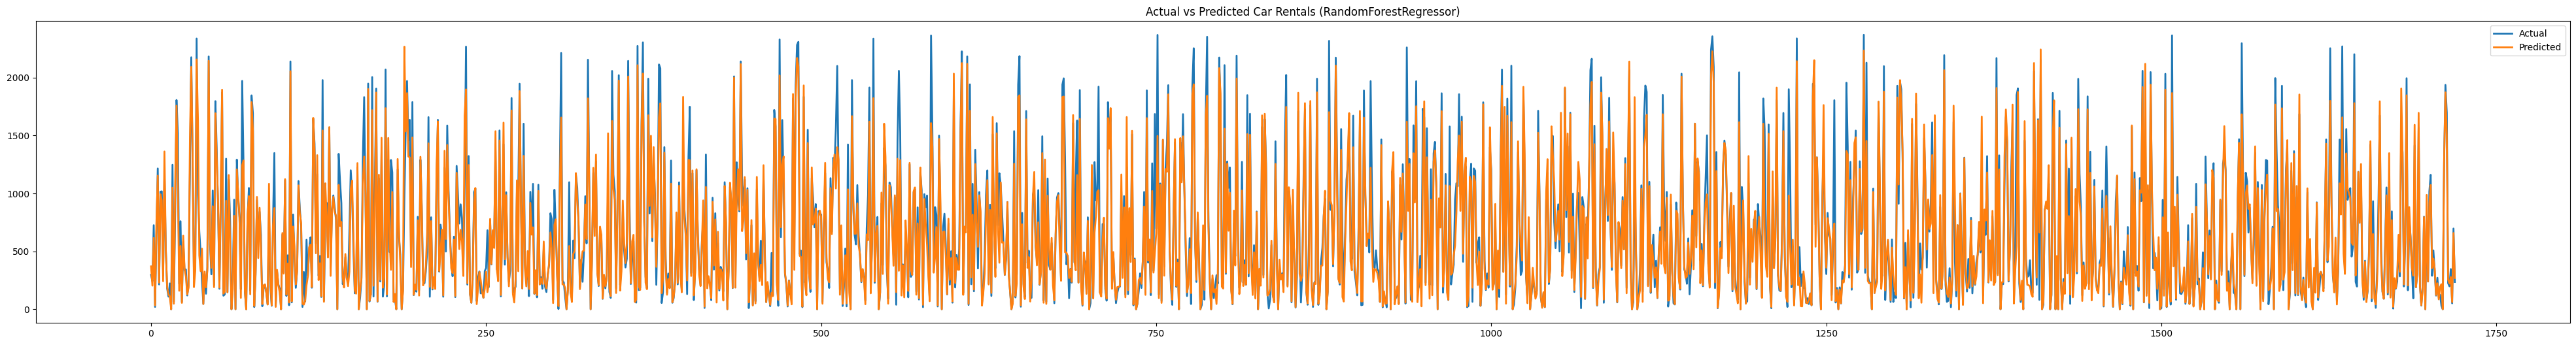

In [29]:
plt.figure(figsize=(50,6))
plt.plot((np.expm1(y_test.values)), label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linewidth=2)
plt.legend()
plt.title("Actual vs Predicted Car Rentals (RandomForestRegressor)")
plt.show()

GridSearchCV with XGBoost

In [30]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

xgb = XGBRegressor(random_state=42, n_jobs=-1)

grid = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train_log)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 300],
                         'subsample': [0.7, 0.9]},
             scoring='neg_mean_absolute_error', verbose=1)

Predict and evaluate

In [31]:
y_pred_log = grid.best_estimator_.predict(X_test)
y_pred = np.expm1(y_pred_log) 

Calculate performance

In [32]:
XGBoost_MAE = mean_absolute_error(np.expm1(y_test), y_pred)
XGBoost_RMSE = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
XGBoost_R2= r2_score(np.expm1(y_test), y_pred)

print("XGBoost R2:",XGBoost_R2)
print("XGBoost_RMSE: ",XGBoost_RMSE)
print("XGBoost_MAE: ",XGBoost_MAE)

XGBoost R2: 0.9455919403808116
XGBoost_RMSE:  139.9697469238928
XGBoost_MAE:  76.53765421571194


Graphical presentation

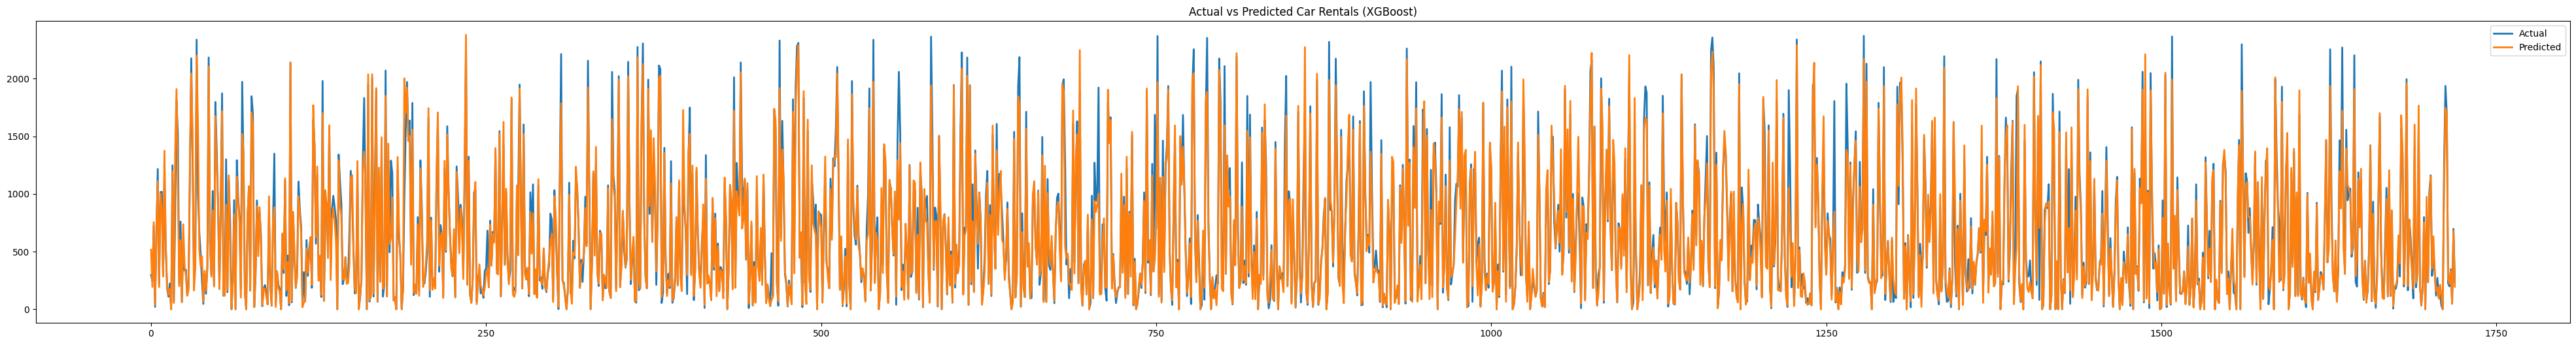

In [33]:
plt.figure(figsize=(50,6))
plt.plot((np.expm1(y_test.values)), label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linewidth=2)
plt.legend()
plt.title("Actual vs Predicted Car Rentals (XGBoost)")
plt.show()

comaprison b/w all models dataset

In [34]:
com=[['Model','R2','RMSE','MAE'],
     ['Linear_Regression',Linear_Regression_R2,Linear_Regression_RMSE,Linear_Regression_mae],
     ['RandomForest',RandomForest_R2,RandomForest_RMSE,RandomForest_mae],
     ['XGBoost',XGBoost_R2,XGBoost_RMSE,XGBoost_MAE]]
compare = pd.DataFrame(com[1:], columns=com[0]) 
compare = compare.set_index('Model').T


In [35]:
compare

Model,Linear_Regression,RandomForest,XGBoost
R2,0.553927,0.915540,0.945592
RMSE,400.779494,174.392106,139.969747
MAE,249.303356,95.694956,76.537654
